# RMBR Regression & Residual Analysis Pipeline

In [2]:

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv("./data/RMBR4-2_export_test.csv")
axis_cols = [f"Axis #{i}" for i in range(1, 9)]
df["Time_dt"] = pd.to_datetime(df["Time"], errors="coerce", utc=True)
df = df.dropna(subset=["Time_dt"])
t0 = df["Time_dt"].min()
df["Time_s"] = (df["Time_dt"] - t0).dt.total_seconds()
for c in axis_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df.head()


,Trait,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8,Axis #9,Axis #10,Axis #11,Axis #12,Axis #13,Axis #14,Time,Time_dt,Time_s
0,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:23.660Z,2022-10-17 12:18:23.660000+00:00,0.000
1,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:25.472Z,2022-10-17 12:18:25.472000+00:00,1.812
2,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:27.348Z,2022-10-17 12:18:27.348000+00:00,3.688
3,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:29.222Z,2022-10-17 12:18:29.222000+00:00,5.562
4,current,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-17T12:18:31.117Z,2022-10-17 12:18:31.117000+00:00,7.457


In [3]:

summary_rows = []
for c in axis_cols:
    d = df.dropna(subset=[c]).copy()
    if len(d) < 2:
        continue
    X = d[["Time_s"]].values
    y = d[c].values
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(X)
    r2 = r2_score(y, y_hat)
    resid = y - y_hat
    resid_std = float(np.nanstd(resid, ddof=1)) if len(resid) > 1 else float("nan")
    summary_rows.append({"Axis": c, "Slope": float(m.coef_[0]), "Intercept": float(m.intercept_),
                         "R2": r2, "Residual_STD": resid_std, "Alert_Threshold(3xSTD)": 3*resid_std})
summary_df = pd.DataFrame(summary_rows)
summary_df


,Axis,Slope,Intercept,R2,Residual_STD,Alert_Threshold(3xSTD)
0,Axis #1,-1.176729e-07,0.730542,1.584839e-06,2.162118,6.486354
1,Axis #2,2.194203e-06,3.523886,5.442193e-05,6.879775,20.639324
2,Axis #3,-5.777186e-07,2.733898,6.833765e-06,5.111883,15.335650
3,Axis #4,3.890034e-07,0.604357,3.264337e-05,1.574871,4.724613
4,Axis #5,8.381178e-08,0.951103,8.520927e-07,2.100185,6.300555
5,Axis #6,4.744455e-07,0.580077,3.654041e-05,1.815465,5.446394
6,Axis #7,5.537186e-07,0.847563,3.494045e-05,2.166773,6.500319
7,Axis #8,8.499989e-08,0.098748,2.159701e-05,0.423071,1.269212


## Residual Analysis
We compute residuals (observed - predicted) for each axis model, visualize their distributions, and detect outliers.

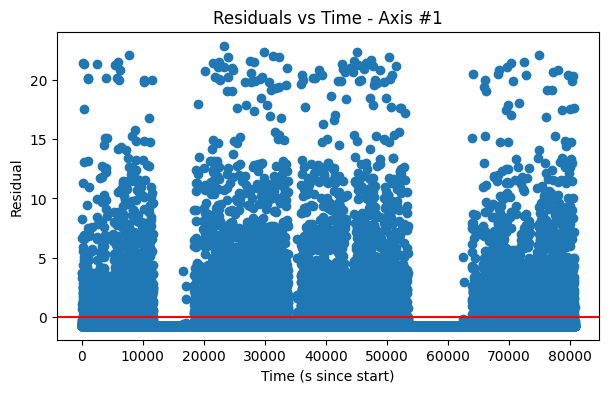

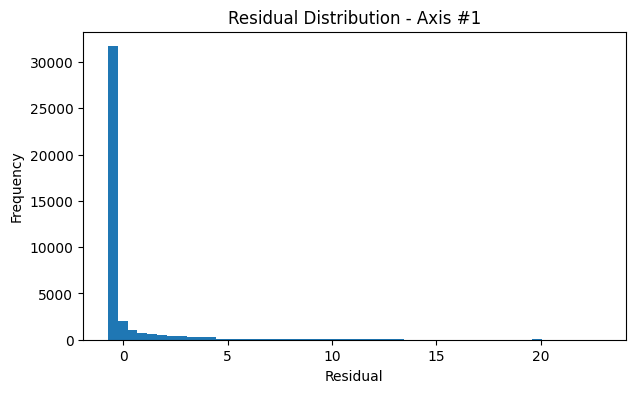

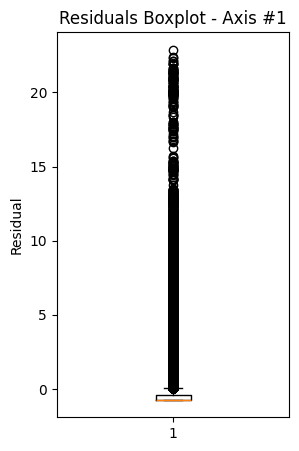

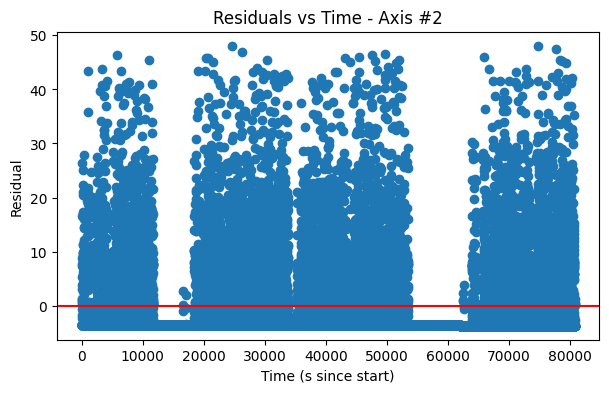

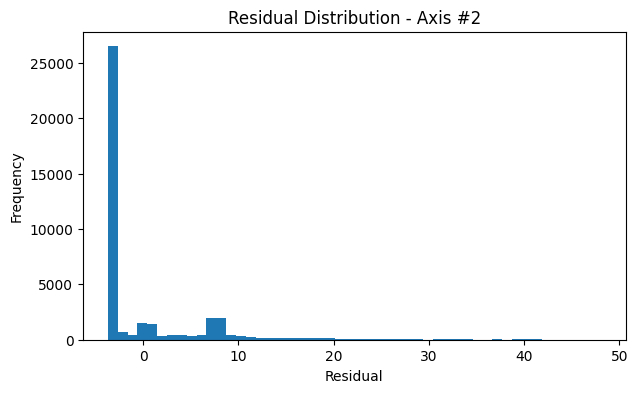

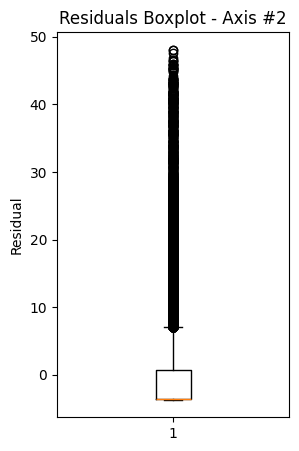

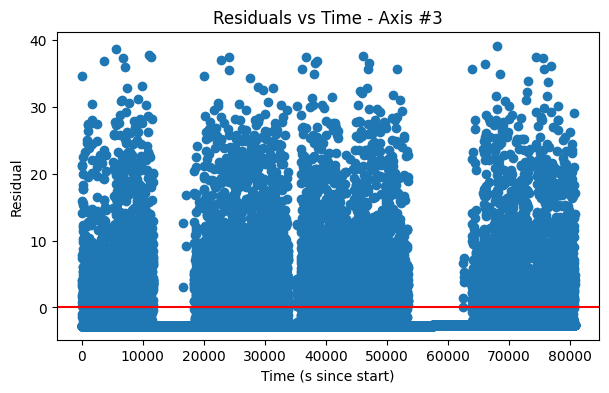

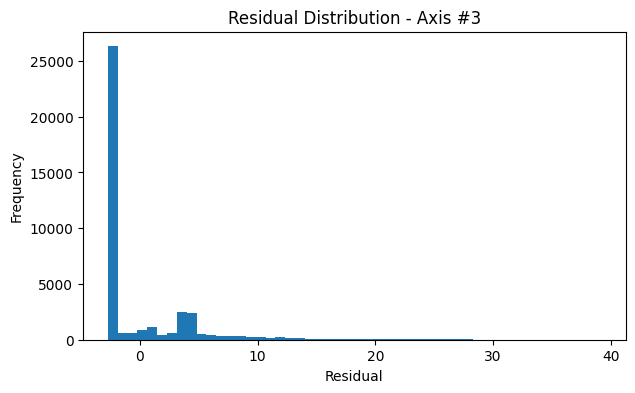

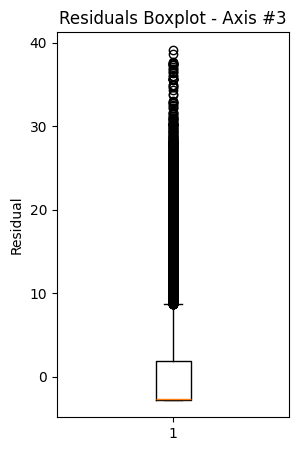

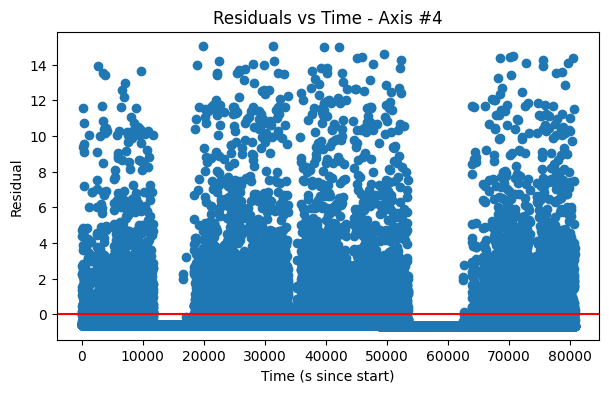

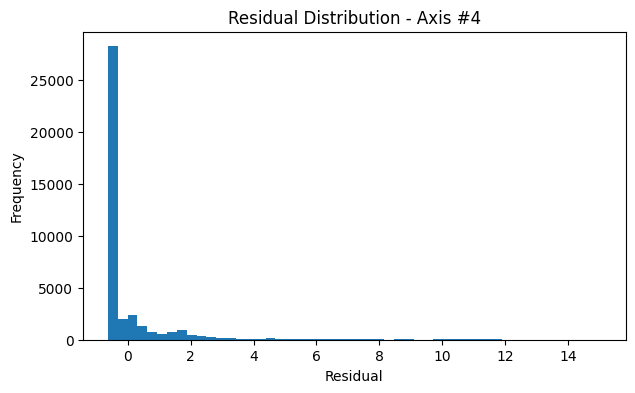

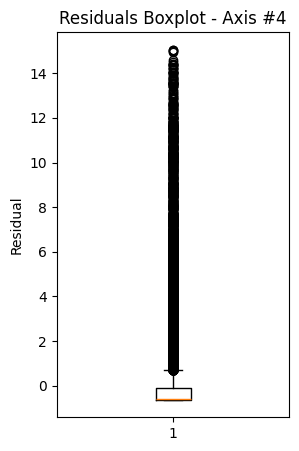

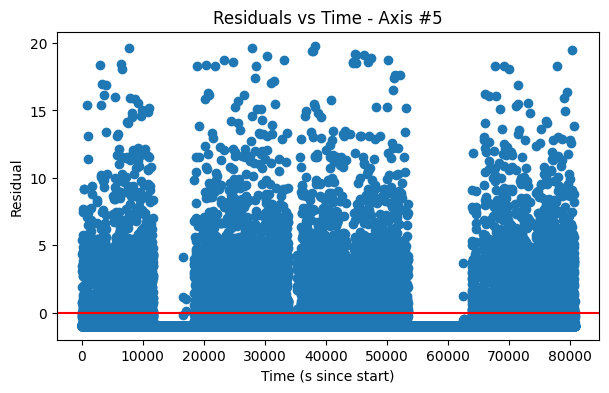

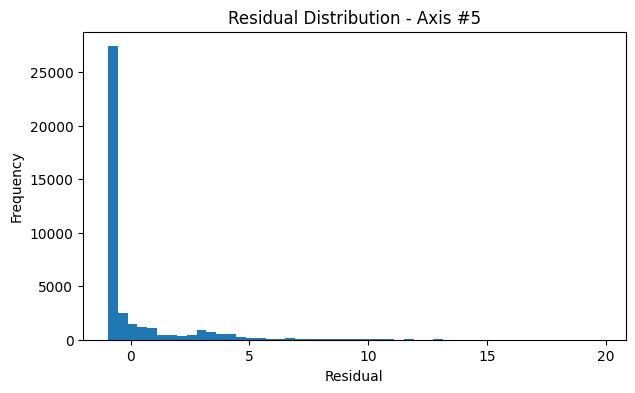

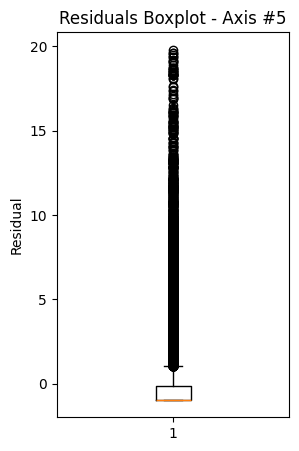

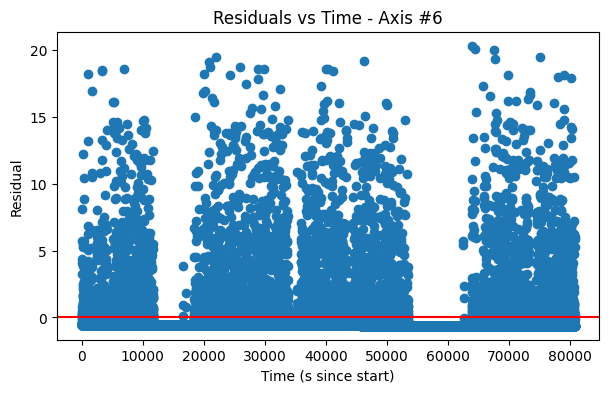

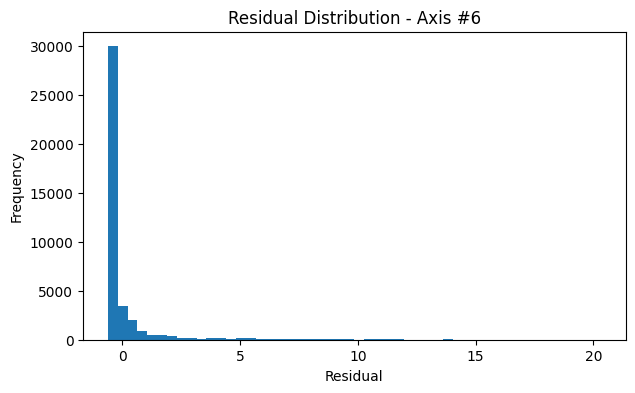

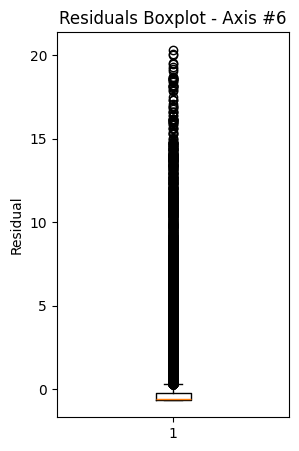

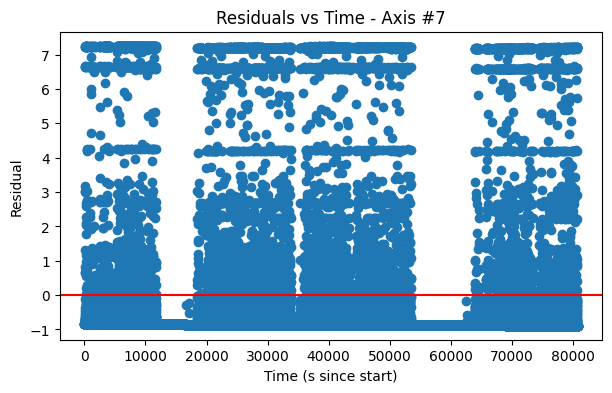

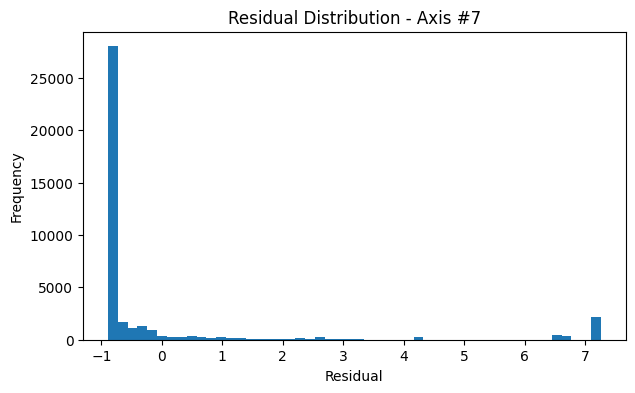

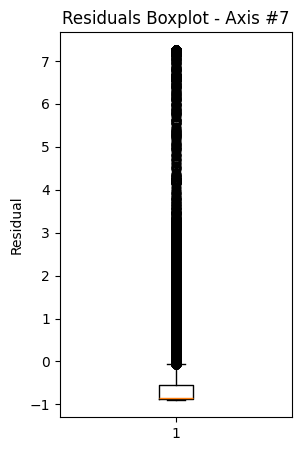

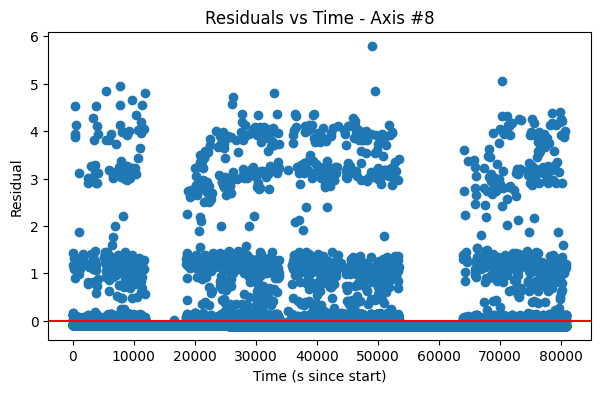

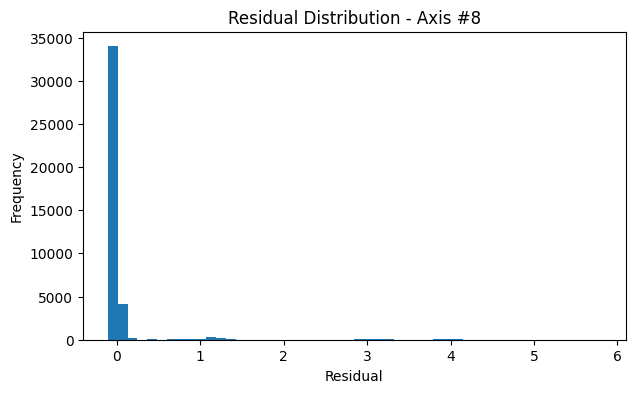

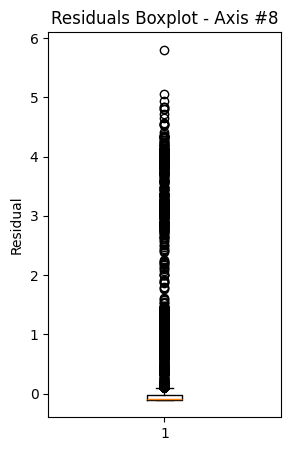

,Axis,Residual_Mean,Residual_STD,Outlier_Count,Total,Outlier_%
0,Axis #1,-5.731339e-17,2.162118,6500,39672,16.384352
1,Axis #2,2.980296e-16,6.879775,6894,39672,17.377495
2,Axis #3,3.668057e-16,5.111883,2311,39672,5.825267
3,Axis #4,6.304473e-17,1.574871,5604,39672,14.125832
4,Axis #5,-8.023874e-17,2.100185,6144,39672,15.486993
5,Axis #6,-1.203581e-16,1.815465,5317,39672,13.402400
6,Axis #7,-1.719402e-16,2.166773,6594,39672,16.621295
7,Axis #8,0.000000e+00,0.423071,1942,39672,4.895140


In [4]:

residuals_dict = {}
resid_summary_rows = []

for c in axis_cols:
    d = df.dropna(subset=[c]).copy()
    if len(d) < 2:
        continue
    X = d[["Time_s"]].values
    y = d[c].values
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(X)
    resid = y - y_hat
    residuals_dict[c] = resid

    # Scatter residuals vs time
    plt.figure(figsize=(7,4))
    plt.scatter(d["Time_s"], resid)
    plt.axhline(0, color="red")
    plt.title(f"Residuals vs Time - {c}")
    plt.xlabel("Time (s since start)"); plt.ylabel("Residual")
    plt.show()

    # Histogram
    plt.figure(figsize=(7,4))
    plt.hist(resid, bins=50)
    plt.title(f"Residual Distribution - {c}")
    plt.xlabel("Residual"); plt.ylabel("Frequency")
    plt.show()

    # Boxplot
    plt.figure(figsize=(3,5))
    plt.boxplot(resid, vert=True)
    plt.title(f"Residuals Boxplot - {c}")
    plt.ylabel("Residual")
    plt.show()

    # Outlier detection (IQR)
    q1, q3 = np.percentile(resid, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = np.sum((resid < lower) | (resid > upper))
    resid_summary_rows.append({
        "Axis": c, "Residual_Mean": float(np.mean(resid)), "Residual_STD": float(np.std(resid, ddof=1)),
        "Outlier_Count": int(outliers), "Total": len(resid),
        "Outlier_%": float(100*outliers/len(resid)) if len(resid)>0 else np.nan
    })

resid_summary = pd.DataFrame(resid_summary_rows)
resid_summary


## Threshold Definition

We define thresholds for triggering alerts or errors based on sustained deviations:

- **MinC**: minimum deviation (kWh above regression line) for an **Alert**.
- **MaxC**: maximum deviation (kWh above regression line) for an **Error**.
- **T**: minimum continuous duration (seconds) that the deviation must persist.

In [5]:

# Example threshold values (tune as needed)
MinC = 1.0   # kWh above regression line to trigger Alert
MaxC = 2.5   # kWh above regression line to trigger Error
T = 30       # seconds deviation must persist

print("Thresholds set:")
print("MinC (Alert):", MinC)
print("MaxC (Error):", MaxC)
print("T (duration in seconds):", T)


Thresholds set:
MinC (Alert): 1.0
MaxC (Error): 2.5
T (duration in seconds): 30


## Alert/Error Rules

We implement rules based on thresholds:

- **Alert**: residual ≥ MinC kWh for ≥ T seconds continuously
- **Error**: residual ≥ MaxC kWh for ≥ T seconds continuously

In [9]:

def detect_events(df, axis, MinC, MaxC, T):
    d = df.dropna(subset=[axis]).copy()
    if len(d) < 2:
        return []
    X = d[["Time_s"]].values
    y = d[axis].values
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(X)
    resid = y - y_hat
    d["residual"] = resid

    events = []
    state = None
    start_time = None

    for t, r in zip(d["Time_s"], resid):
        if r >= MaxC:
            if state != "Error":
                state = "Error"
                start_time = t
            elif t - start_time >= T:
                events.append({"Axis": axis, "Type": "Error", "Start": start_time, "End": t, "Duration": t - start_time})
        elif r >= MinC:
            if state != "Alert":
                state = "Alert"
                start_time = t
            elif t - start_time >= T:
                events.append({"Axis": axis, "Type": "Alert", "Start": start_time, "End": t, "Duration": t - start_time})
        else:
            state = None
            start_time = None
    return events

# Example run on Axis #1
events_axis1 = detect_events(df, "Axis #1", MinC, MaxC, T)
events_axis1[:8]  # show first 8 events detected


[]

## Multi-Axis Event Detection

We now run the alert/error detection across all Axes #1–#8 and produce a consolidated event log.

In [11]:

all_events = []

for axis in axis_cols:
    events = detect_events(df, axis, MinC, MaxC, T)
    all_events.extend(events)

events_df = pd.DataFrame(all_events)
if not events_df.empty:
    events_df.to_csv("./data/events_log.csv", index=False)
events_df.head(20)


,Axis,Type,Start,End,Duration
0,Axis #2,Error,2615.288,2961.274,345.986
1,Axis #2,Error,2615.288,2963.171,347.883
2,Axis #2,Error,2615.288,2965.171,349.883
3,Axis #2,Error,2615.288,2967.149,351.861
4,Axis #2,Error,2615.288,2969.138,353.850
5,Axis #2,Error,2615.288,2971.057,355.769
6,Axis #2,Error,2615.288,2973.007,357.719
7,Axis #2,Error,2615.288,2974.873,359.585
8,Axis #3,Error,505.093,919.475,414.382
9,Axis #3,Error,505.093,921.424,416.331


The consolidated event log is saved to `events_log.csv`. It contains Axis, Type (Alert/Error), Start time, End time, and Duration (s).

## Synthetic Testing Data Generation

We use the training metadata to generate synthetic testing data. This allows us to run predictions and alerts on unseen-but-realistic samples.

In [13]:

from numpy.random import default_rng
rng = default_rng(42)

test_size = 1000  # number of synthetic rows

# Sample times uniformly across the observed range
time_range = (df["Time_s"].min(), df["Time_s"].max())
synthetic_time = np.linspace(time_range[0], time_range[1], test_size)

synthetic = pd.DataFrame({"Time_s": synthetic_time})

for c in axis_cols:
    d = df.dropna(subset=[c]).copy()
    if len(d) < 2:
        continue
    X = d[["Time_s"]].values
    y = d[c].values
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(synthetic[["Time_s"]].values)

    # Add Gaussian noise based on training residual std
    resid_std = np.std(y - m.predict(X), ddof=1)
    noise = rng.normal(0, resid_std, size=test_size)
    synthetic[c] = y_hat + noise

synthetic_path = "./data/synthetic_test.csv"
synthetic.to_csv(synthetic_path, index=False)
synthetic.head()


,Time_s,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,0.000000,1.389376,3.116035,0.423577,2.571406,1.482879,0.111774,1.335339,-0.519242
1,80.875844,-1.518036,-1.493266,-0.670038,1.687415,2.831234,0.036410,0.732025,-0.278036
2,161.751688,2.353087,0.672760,4.952412,3.700817,1.525142,-0.684607,2.719838,-0.205505
3,242.627532,2.764126,7.885579,4.021208,-1.833186,5.653084,1.358088,2.162350,0.010845
4,323.503375,-3.487864,3.545189,-4.447420,0.186575,3.953948,1.006223,-5.621857,-0.223196


The synthetic test dataset is saved to `synthetic_test.csv`. It mirrors the training patterns with added noise to simulate unseen observations.

## Visualize Alerts/Errors

We overlay detected Alert/Error events on the regression plots for each axis and annotate them with duration.

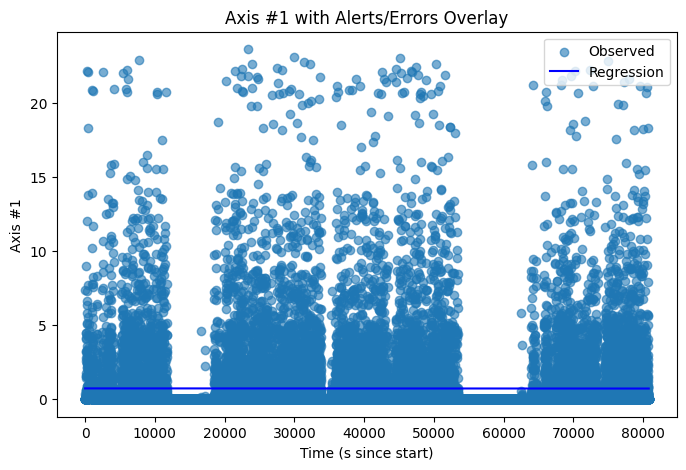

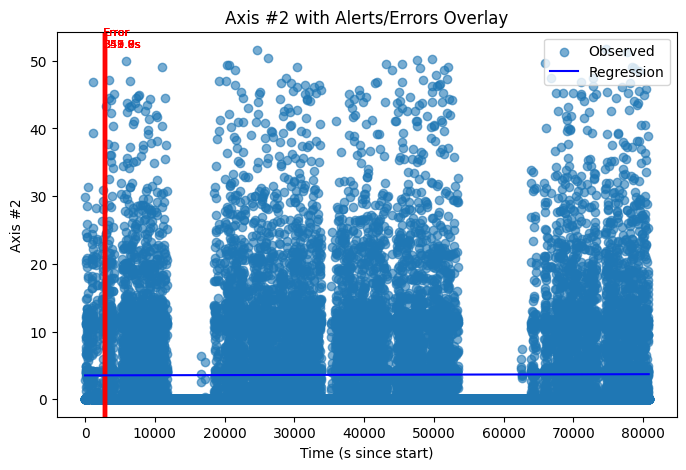

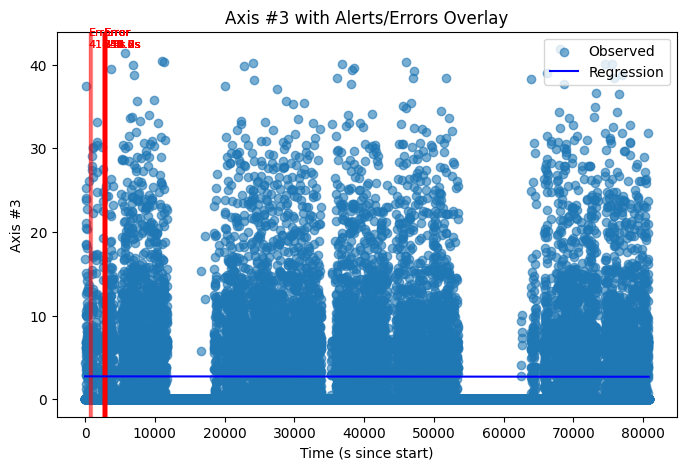

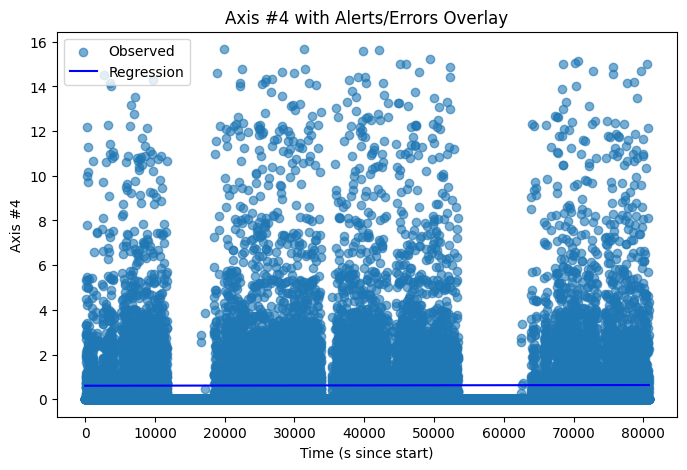

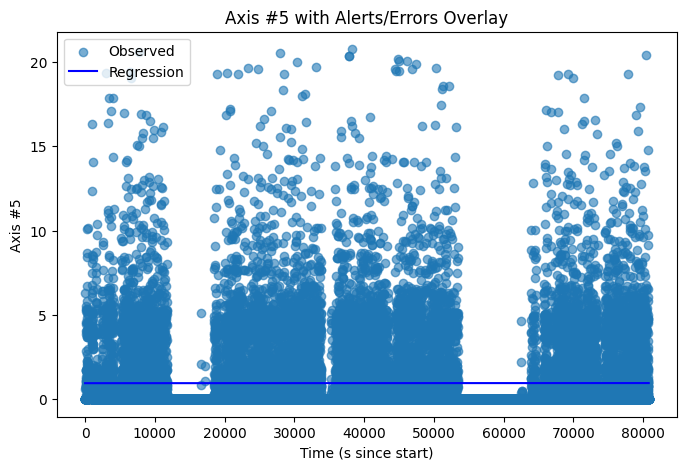

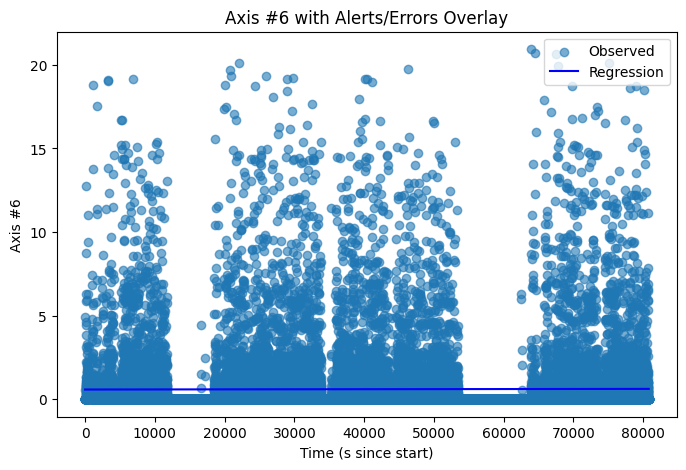

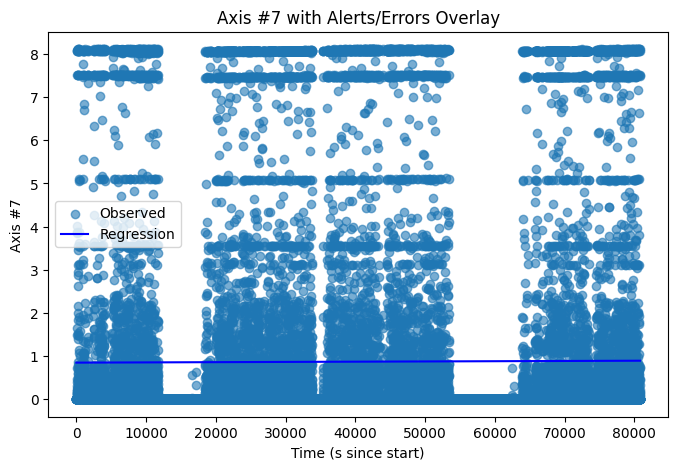

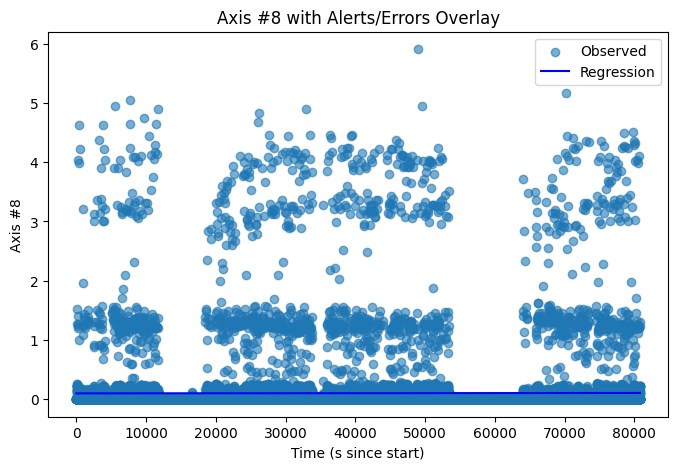

In [14]:

for axis in axis_cols:
    d = df.dropna(subset=[axis]).copy()
    if len(d) < 2:
        continue
    X = d[["Time_s"]].values
    y = d[axis].values
    m = LinearRegression().fit(X, y)
    y_hat = m.predict(X)

    plt.figure(figsize=(8,5))
    plt.scatter(X.flatten(), y, label="Observed", alpha=0.6)
    plt.plot(X.flatten(), y_hat, color="blue", label="Regression")

    # Overlay Alert/Error events
    if 'events_df' in globals() and not events_df.empty:
        evs = events_df[events_df["Axis"] == axis]
        for _, ev in evs.iterrows():
            color = "orange" if ev["Type"] == "Alert" else "red"
            plt.axvspan(ev["Start"], ev["End"], color=color, alpha=0.3)
            plt.text(ev["Start"], max(y), f"{ev['Type']}\n{ev['Duration']:.1f}s",
                     color=color, fontsize=8, verticalalignment="bottom")

    plt.title(f"{axis} with Alerts/Errors Overlay")
    plt.xlabel("Time (s since start)")
    plt.ylabel(axis)
    plt.legend()
    plt.show()


## Log Results

We log all detected Alert/Error events into a structured CSV file, and optionally into a database table if `DATABASE_URL` is configured.

In [52]:
import os
import psycopg2
from dotenv import load_dotenv

load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")

if DATABASE_URL and DATABASE_URL.startswith("postgresql+psycopg://"):
    DATABASE_URL = DATABASE_URL.replace("postgresql+psycopg://", "postgresql://", 1)

try:
    if DATABASE_URL and 'events_df' in globals() and not events_df.empty:
        with psycopg2.connect(DATABASE_URL) as conn:
            with conn.cursor() as cur:
                cur.execute("""
                CREATE TABLE IF NOT EXISTS rmbr_events (
                    id SERIAL PRIMARY KEY,
                    axis TEXT,
                    type TEXT,
                    start DOUBLE PRECISION,
                    end_time DOUBLE PRECISION,
                    duration DOUBLE PRECISION
                );
                """)
                conn.commit()

                for _, row in events_df.iterrows():
                    cur.execute(
                        """
                        INSERT INTO rmbr_events (axis, type, start, end_time, duration)
                        VALUES (%s, %s, %s, %s, %s)
                        """,
                        (row["Axis"], row["Type"], row["Start"], row["End"], row["Duration"])
                    )
                conn.commit()

        print("✅ Events also logged to database.")
    else:
        print("DATABASE_URL not set or no events to log. Skipping DB logging.")

except Exception as e:
    print("DB logging failed:", e)




DB logging failed: connection to server at "ep-hidden-flower-a8nkdi05.eastus2.azure.neon.tech" (2604:5580:22::34a7:bc8f), port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "ep-hidden-flower-a8nkdi05.eastus2.azure.neon.tech" (52.167.188.143), port 5432 failed: ERROR:  password authentication failed for user 'myuser'
connection to server at "ep-hidden-flower-a8nkdi05.eastus2.azure.neon.tech" (52.167.188.143), port 5432 failed: ERROR:  connection is insecure (try using `sslmode=require`)

